In [1]:
import pandas as pd
import joblib
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Part 7 – Executing with Live Data

# Loading the live data

In [2]:

live_data = pd.read_csv("live_data.csv") 

# Loading the trained model

In [3]:

model = joblib.load("airbnb_price_model.joblib") 

# Database connection details

In [4]:

host = r'127.0.0.1'
db = r'MSDS610'
user = r'postgres'
pw = r'12345'
port = r'5432'
db_conn = create_engine(f"postgresql://{user}:{pw}@{host}:{port}/{db}")
cleaning_steps = pd.read_sql("SELECT * FROM cleaned.cleaning_steps", db_conn)
feature_engineering = pd.read_sql("SELECT * FROM cleaned.feature_engineering", db_conn)

In [5]:
cleaning_steps

,field,action,values
0,reviews_per_month,fillna(0),
1,room_type,one-hot encode,
2,neighbourhood,one-hot encode,
3,price,IQR_trim,"(-72.50, 291.50)"


In [6]:
feature_engineering

,feature_name,description,normalization_method,feature_type
0,reviews_per_availability,Average reviews per available day,MinMaxScaler,engineered
1,price_per_night_min_nights,Effective price per night considering minimum ...,MinMaxScaler,engineered
2,minimum_nights,Minimum nights,MinMaxScaler,original
3,number_of_reviews,Number of reviews,MinMaxScaler,original
4,reviews_per_month,Reviews per month,MinMaxScaler,original
5,calculated_host_listings_count,Calculated host listings count,MinMaxScaler,original
6,availability_365,Availability 365,MinMaxScaler,original


# Preparing Live Data with UDFs

In [7]:
def prepare_live_data(data, cleaning_steps, feature_engineering):
   
    columns_to_drop = ['id', 'name', 'host_id', 'host_name', 'latitude', 'longitude', 'neighbourhood_group', 'last_review']
    data = data.drop(columns=columns_to_drop)

  
    data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

   
    data = pd.get_dummies(data, columns=['room_type', 'neighbourhood'], drop_first=True)

   
    Q1 = data['price'].quantile(0.25)
    Q3 = data['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

    
    data['reviews_per_availability'] = data['number_of_reviews'] / (data['availability_365'] + 1)
    data['price_per_night_min_nights'] = data['price'] / (data['minimum_nights'] + 1)

    
    numerical_cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                      'calculated_host_listings_count', 'availability_365',
                      'reviews_per_availability', 'price_per_night_min_nights']
    scaler = MinMaxScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    return data


prepared_live_data = prepare_live_data(live_data.copy(), cleaning_steps, feature_engineering)


The prepare_live_data function is designed to preprocess the incoming live data to ensure it is consistent with the data used to train the model. This involves several key steps:  it removes irrelevant columns such as 'id', 'name', and location information that are not needed for prediction. Next it handles missing values in the reviews_per_month column by filling them with 0. Third it converts categorical variables 'room_type' and 'neighbourhood' into a numerical format using one-hot encoding. Fourth it addresses potential outliers in the 'price' column by removing data points that fall outside the interquartile range (IQR) defined by 1.5 times the IQR. Next it performs feature engineering to create new features 'reviews_per_availability' and 'price_per_night_min_nights' from existing columns. Finally it normalizes the numerical features using MinMaxScaler to ensure they are on a similar scale which is crucial for the model's performance.  finally this function transforms the raw live data into a clean, consistent, and model ready format.

#   Ensuring Consistent Data Columns for Live Data Predictions

In [8]:

validation_data = pd.read_csv("validation_data.csv")
training_columns = validation_data.drop('price', axis=1).columns
for column in training_columns:
    if column not in prepared_live_data.columns:
        prepared_live_data[column] = 0

prepared_live_data = prepared_live_data[training_columns]

To ensure the live data is compatible with our trained model i first load the validation_data.csv file, which contains the exact columns used during training excluding the target variable 'price'. i then iterate through these training columns, adding any missing columns to the prepared_live_data DataFrame and filling them with zeros effectively handling cases where the live data lacks certain features. Finally i reorderd the columns in the live data to precisely match the training data's order. This process guarantees that the live data has the same structure as the training data ensuring accurate predictions from our model by preventing errors due to missing or misordered features.

# Generating predictions

In [9]:

prepared_live_data['predicted_price'] = model.predict(prepared_live_data)

# Part 8 – Storing the Predictions

# Append the actual price column to the prepared_live_data for comparison

In [10]:

prepared_live_data['price'] = live_data.loc[prepared_live_data.index, 'price']

In [11]:

print(prepared_live_data[['price', 'predicted_price']])

    price  predicted_price
0     200           228.62
1      44            47.96
2      45            49.10
3     255           281.64
4      55            59.88
..    ...              ...
95    155           164.84
96     25            27.98
97    159           175.92
98    144           152.80
99    110           122.10

[93 rows x 2 columns]


Following the preparation of our live data i utilized the trained RandomForestRegressor model to generate price predictions storing these in a new 'predicted_price' column within the prepared_live_data DataFrame. To facilitate a direct comparison i then appended the original 'price' column from the live_data DataFrame ensuring the actual and predicted prices were aligned. The results displaying both actual and predicted prices were then printed for immediate review revealing a sample of the model's performance. Finally to ensure persistent storage and enable further analysis i stored the prepared_live_data DataFrame  containing both actual and predicted prices into the PostgreSQL database as a new table named 'live_data_with_predictions' within the 'cleaned' schema replacing any existing table with the same name and excluding the DataFrame index from the database table.

# Storing predictions in the database 

In [12]:

prepared_live_data.to_sql('live_data_with_predictions', db_conn, schema='analytics', if_exists='replace', index=False)

93

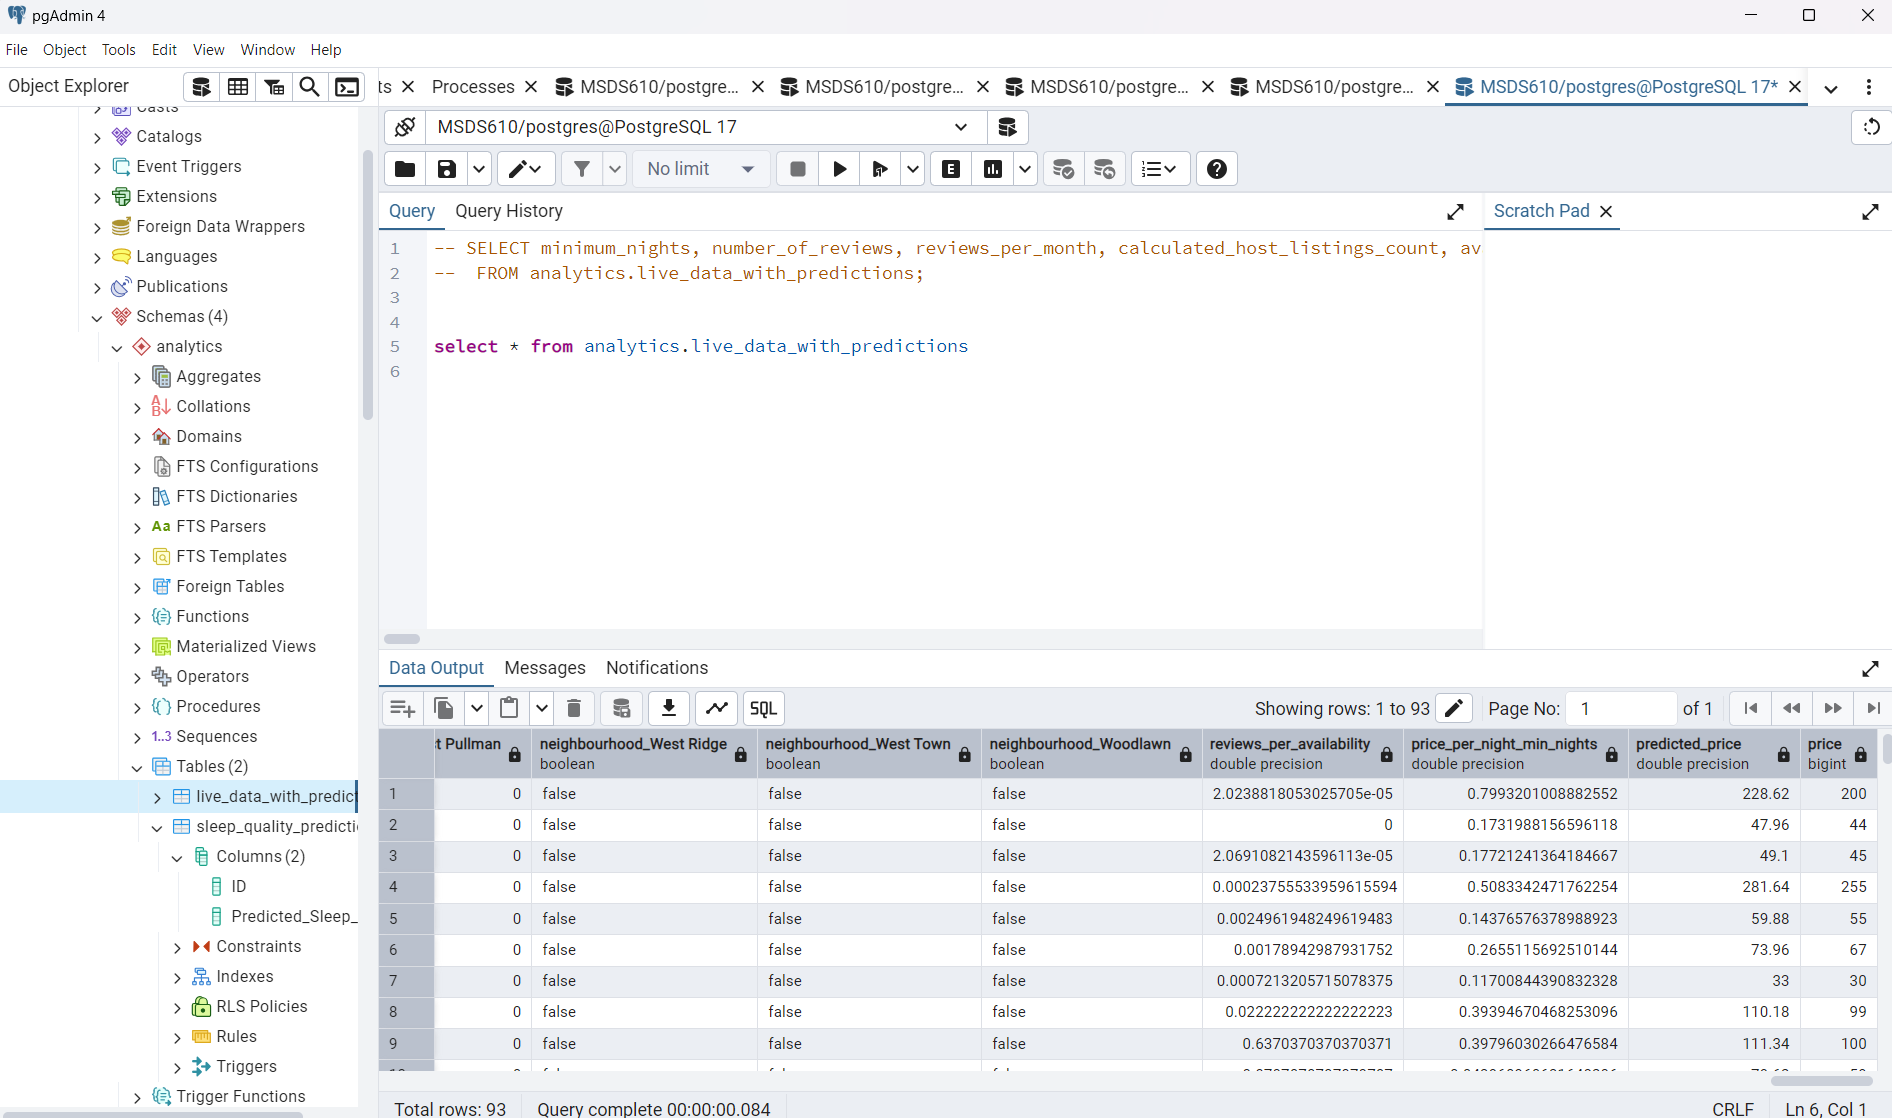

# Part 9 - Insights

# MAE and RMSE

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(prepared_live_data['price'], prepared_live_data['predicted_price'])
rmse = mean_squared_error(prepared_live_data['price'], prepared_live_data['predicted_price'], squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 15.14075077273559
Root Mean Squared Error (RMSE): 21.043444366033345


To quantify the model's predictive accuracy i utilized the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE). The MAE calculated at 15.14 represents the average absolute difference between predicted and actual prices indicating that on average the model's predictions deviate by approximately $15.14. The RMSE with a value of 21.04 also measures prediction error but gives greater weight to larger discrepancies.These metrics provide valuable insight into the model's performance with lower values signifying greater accuracy.

# actual vs predicted prices

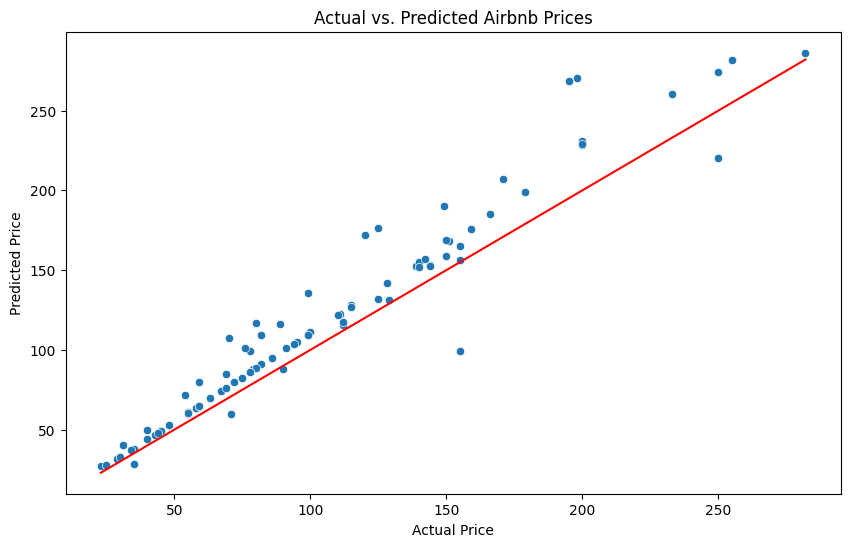

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='predicted_price', data=prepared_live_data)
plt.title('Actual vs. Predicted Airbnb Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([min(prepared_live_data['price']), max(prepared_live_data['price'])], [min(prepared_live_data['price']), max(prepared_live_data['price'])], color='red')
plt.show()

The scatter plot provides a visual representation of the model's predictive performance plotting actual Airbnb prices against their predicted values. Each data point illustrates a specific instance with the red line indicating a scenario of perfect prediction. While the data points generally cluster around this line suggesting a reasonable degree of accuracy the noticeable scatter reveals that the model's predictions are mostly accurate.  The plot indicates that the model's ability to accurately predict prices appears to diminish somewhat at higher price ranges where the data points exhibit a greater spread. Overall the scatter plot provides a clear visual assessment of the model's performance in relation to actual price values.

# Histogram of residuals

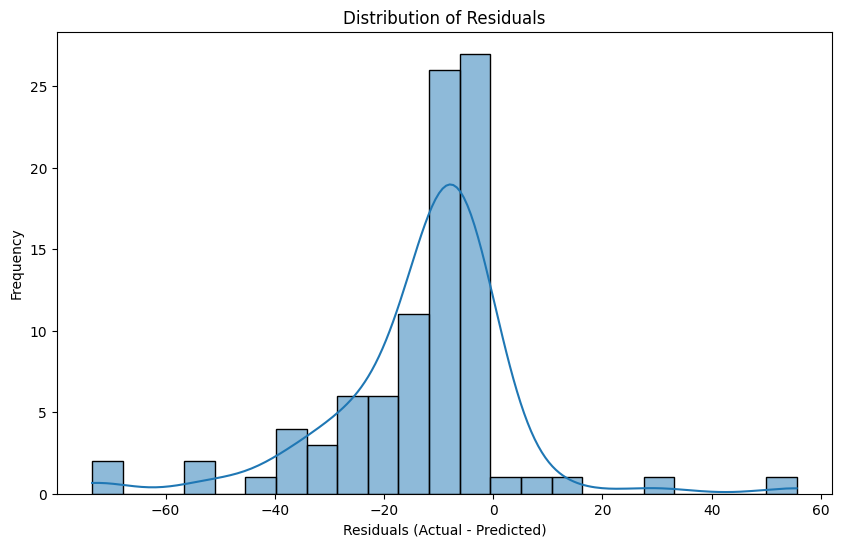

In [15]:

prepared_live_data['residual'] = prepared_live_data['price'] - prepared_live_data['predicted_price']
plt.figure(figsize=(10, 6))
sns.histplot(prepared_live_data['residual'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

To gain further insight into the model's performance i examined the distribution of residuals the differences between actual and predicted prices using a histogram. This distribution appears to be roughly centered around zero with a bell-shaped curve indicating that the model's errors are generally random and unbiased which is a positive sign. However the presence of some data points farther from zero suggests larger prediction errors, and the distribution's slight asymmetry implies that the model's performance may vary across different price ranges or listing characteristics. Overall the residual distribution indicates reasonably good performance 

# percentage error for each prediction

In [16]:

prepared_live_data['percentage_error'] = (abs(prepared_live_data['residual']) / prepared_live_data['price']) * 100
print("\nPercentage Error for Each Prediction (First 10):")
print(prepared_live_data[['price', 'predicted_price', 'percentage_error']].head(10))


Percentage Error for Each Prediction (First 10):
    price  predicted_price  percentage_error
0     200           228.62         14.310000
1      44            47.96          9.000000
2      45            49.10          9.111111
3     255           281.64         10.447059
4      55            59.88          8.872727
5      67            73.96         10.388060
6      30            33.00         10.000000
8      99           110.18         11.292929
9     100           111.34         11.340000
10     59            79.62         34.949153


The percentage error is defined as the absolute difference between the actual and predicted prices, divided by the actual price and multiplied by 100. This metric provides a relative measure of how far off the predictions are from the true values. From this sample we can see that most predictions have a percentage error below 15%, with a few exceptions a 34.95% error for one prediction. This indicates that the model performs reasonably well for most cases 

# descriptive statistics for the percentage errors

In [17]:

print("\nDescriptive Statistics for Percentage Errors:")
print(prepared_live_data['percentage_error'].describe())



Descriptive Statistics for Percentage Errors:
count    93.000000
mean     14.842252
std      10.853114
min       0.916129
25%       9.654676
50%      10.617021
75%      14.390000
max      53.457143
Name: percentage_error, dtype: float64


The mean percentage error is 14.84%, with a standard deviation of 10.85% indicating some variability in the model's accuracy. The minimum percentage error is 0.92% showing that the model can make highly accurate predictions in some cases while the maximum error is 53.46% highlighting areas where the model struggles. The median percentage error is 10.62% which suggests that half of the predictions have an error of 10.62% or less.

# Calculating the percentage of predictions within a certain error threshold (e.g., 10%)

In [18]:

error_threshold = 10
within_threshold = (prepared_live_data['percentage_error'] <= error_threshold).sum()
total_predictions = len(prepared_live_data)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"\nPercentage of predictions within {error_threshold}% error: {percentage_within_threshold:.2f}%")


Percentage of predictions within 10% error: 32.26%


This means that 32.26% of the predictions are within 10% of the actual prices.  this is a reasonable starting point

# Feature Importance

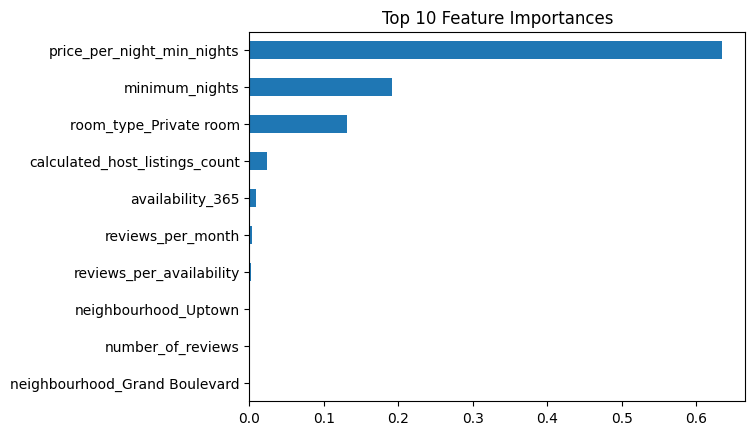

In [19]:
feature_importance = pd.Series(model.feature_importances_, index=validation_data.drop('price', axis=1).columns)
feature_importance_sorted = feature_importance.nlargest(10).sort_values(ascending=True)
feature_importance_sorted.plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()

The top 10 feature importances as determined by our RandomForestRegressor model for predicting Airbnb listing prices in Chicago reveal several key insights.  price_per_night_min_nights is the most significant predictor followed by minimum_nights emphasizing the critical role of pricing strategies and stay durations. The categorical feature room_type_Private room is the most influential among room types. Other important factors include calculated_host_listings_count, availability_365, reviews_per_month, and reviews_per_availability all contributing to the model's predictive power. Location as indicated by neighbourhood_Uptown and neighbourhood_Grand Boulevard also plays a role although less prominent than the other features.  number_of_reviews is a contributing factor suggesting that listing popularity influences pricing. Overall this analysis highlights the multifaceted nature of Airbnb pricing where a combination of pricing metrics, property characteristics and location influence the final price.

# Part 10 - Reflection

### Challenges
Throughout this project I encountered several challenges that tested my problem-solving skills and deepened my understanding of the data science workflow. One of the most significant challenges was **handling missing data**  particularly in the reviews_per_month column. Deciding whether to impute missing values or remove them  as each approach had its trade offs. I ultimately chose to fill missing values with 0 assuming that no reviews meant the listing had not been reviewed yet. However this decision might have introduced some bias and alternative strategies like imputing based on neighborhood or room type could be explored in the future.

Another challenge was **feature engineering**. Creating meaningful features like reviews_per_availability and price_per_night_min_nights required a deep understanding of the dataset and the problem domain. While these features improved the model's performance the process was time consuming and iterative. I learned that feature engineering requires creativity and domain knowledge.

Finally **model tuning** was computationally intensive especially with a large dataset and multiple hyperparameters. Using GridSearchCV to find the best parameters for the Random Forest model was effective but required significant computational resources. Balancing model complexity and performance was a key challenge and I had to make adjustments to ensure the model was both accurate and efficient.

# What I Enjoyed

What I enjoyed most about this project was the feature engineering and model-building process. Creating new features like reviews_per_availability and price_per_night_min_nights allowed me to think creatively about how to capture meaningful patterns in the data. For example reviews_per_availability helped me understand how the frequency of reviews relative to a listing's availability could influence its perceived value, while price_per_night_min_nights provided insights into how minimum stay requirements affect pricing strategies. These features not only improved the model's performance but also deepened my understanding of the underlying factors that drive Airbnb pricing.

I also found the process of training and tuning the Random Forest model to be fascinating. Experimenting with hyperparameters like n_estimators, max_depth, and min_samples_split allowed me to see how small adjustments could significantly impact the model's accuracy. Using GridSearchCV to systematically explore different combinations of hyperparameters was particularly rewarding as it gave me a structured way to optimize the model. The moment when the model started producing accurate predictions was incredibly satisfying as it validated the effort I had put into data preparation, feature engineering, and model tuning.

Another aspect I enjoyed was the problem-solving nature of the project. From handling missing data to addressing outliers and ensuring consistency between training and live data each step required careful thought and decision-making. This hands-on experience helped me develop a more intuitive understanding of the challenges involved in real-world data science projects.

# Better Understanding of the Steps
This project gave me a much better understanding of what it takes to deploy a model to production. I learned that deployment is not just about building a high-performing model but also about ensuring consistency, reproducibility, and scalability. For example writing User-Defined Functions (UDFs) to preprocess live data was a critical step in ensuring that the live data was prepared in the same way as the training data. This highlighted the importance of creating robust pipelines that can handle new data efficiently and consistently.

Storing predictions in a PostgreSQL database was another enlightening experience. It taught me how to integrate machine learning models with databases, which is a crucial skill for deploying models in production environments. By saving the cleaned data, feature engineering steps, and predictions in different schemas like raw, cleaned, and analytics I gained a clearer picture of how data flows through a machine learning pipeline.

I also learned the importance of documentation throughout the process. Creating tables in the database to document cleaning steps and feature engineering decisions ensured that the entire process was transparent and reproducible. This practice not only helped me keep track of my work but also made it easier to explain my decisions to others.

While there’s still much to learn this project has given me a solid foundation and a clearer picture of the steps involved in taking a model from development to production. It has also sparked my interest in exploring more advanced techniques for model deployment such as containerization  Docker and cloud-based solutions  AWS SageMaker, Google AI Platform.


# Conclusion
This project was a valuable learning experience that allowed me to apply my data science skills to a real-world problem. By analyzing the Chicago Airbnb dataset I gained insights into the factors that influence nightly pricing such as property type, location, minimum stay requirements, and host activity. These insights could help Airbnb hosts optimize their pricing strategies and guide potential investors in making informed decisions.

While the model achieved good  accuracy there is always room for improvement. For example incorporating additional data sources, such as seasonal trends or local events, could further enhance the model's predictive power. Additionally experimenting with more advanced algorithms such as Gradient Boosting Machines (GBM) or Neural Networks could yield better results.

